In [1]:
import os

import pandas as pd
import torch

from utils.dataset import VocabCreator
from utils.dataset import LemmaDataSet
from utils.constants import PAD_TOKEN, EOW_TOKEN, SOW_TOKEN, UNK_TOKEN
from evaluation.evaluation import LemmatizatorEvaluator, EVALUATION_PATH
from evaluation.metrics import AccuracyMetric, EditDistanceMetric, Metrics

# Data

In [2]:
data = pd.read_csv('csv/test.csv')
data

,Unnamed: 0,word,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category
0,143445,საჩემოა,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium
1,805277,საჭმელ-სასმელით,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium
2,902975,დავნაძლევდით,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium
3,55733,ჯორჯი,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high
4,228515,გამეშვი,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410093,671912,ყმაშია,ყმა,N,2,6,3,2.000000,low,low,greater,False,low
410094,339503,სათხარი,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low
410095,1060380,ასანთმასალებისკენ,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low
410096,1315693,პაულუმაც,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium


In [3]:
data = data.drop(columns=['Unnamed: 0'])
data

,word,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category
0,საჩემოა,საჩემო,A,10,7,6,1.166667,low,low,greater,False,medium
1,საჭმელ-სასმელით,საჭმელსასმელი,N,15,15,13,1.153846,high,high,greater,False,medium
2,დავნაძლევდით,დანაძლევება,V,4,12,11,1.090909,high,high,greater,False,medium
3,ჯორჯი,ჯორჯ,N,330,5,4,1.250000,low,low,greater,False,high
4,გამეშვი,გაშვება,V,13,7,7,1.000000,low,low,equal,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
410093,ყმაშია,ყმა,N,2,6,3,2.000000,low,low,greater,False,low
410094,სათხარი,სათხარი,A,1,7,7,1.000000,low,low,equal,False,low
410095,ასანთმასალებისკენ,ასანთმასალა,N,1,17,11,1.545455,high,high,greater,False,low
410096,პაულუმაც,პაულუ,N,4,8,5,1.600000,low,low,greater,False,medium


## Preparation

In [4]:
MAX_LENGTH = 37
AVG_LENGTH = data.lemma.str.len().mean()
AVG_LENGTH


8.114172709937625

In [5]:
vocab = VocabCreator(LemmaDataSet(data), default_token=PAD_TOKEN,
                     special_tokens=[EOW_TOKEN, UNK_TOKEN, PAD_TOKEN, SOW_TOKEN]).make()
len(vocab)

39

In [6]:

evaluator = LemmatizatorEvaluator(data, Metrics([AccuracyMetric(), EditDistanceMetric()]), EVALUATION_PATH, 'base_model', MAX_LENGTH)

# Base Model Evaluation

## Model

In [7]:
from models.models import Seq2Seq, EncoderRNN, DecoderRNN

model = Seq2Seq(EncoderRNN(vocab_dim=len(vocab), emb_dim=64 ,hidden_dim=64), DecoderRNN(vocab_dim=len(vocab), emb_dim=64, hidden_dim=64), sow_token=vocab[SOW_TOKEN], max_length=MAX_LENGTH)


In [8]:
# MODEL_NAME = 'base_model_v0.pt'
MODEL_WEIGHTS = 'base_model_v2.pt'

In [9]:
# model = torch.jit.load(os.path.join('models', MODEL_NAME))
model.load_state_dict(torch.load(os.path.join('weights', MODEL_WEIGHTS)))
model.eval()
print(f'Number of Parameters: {sum(p.numel() for p in model.parameters())}')

Number of Parameters: 57447


# Evaluation

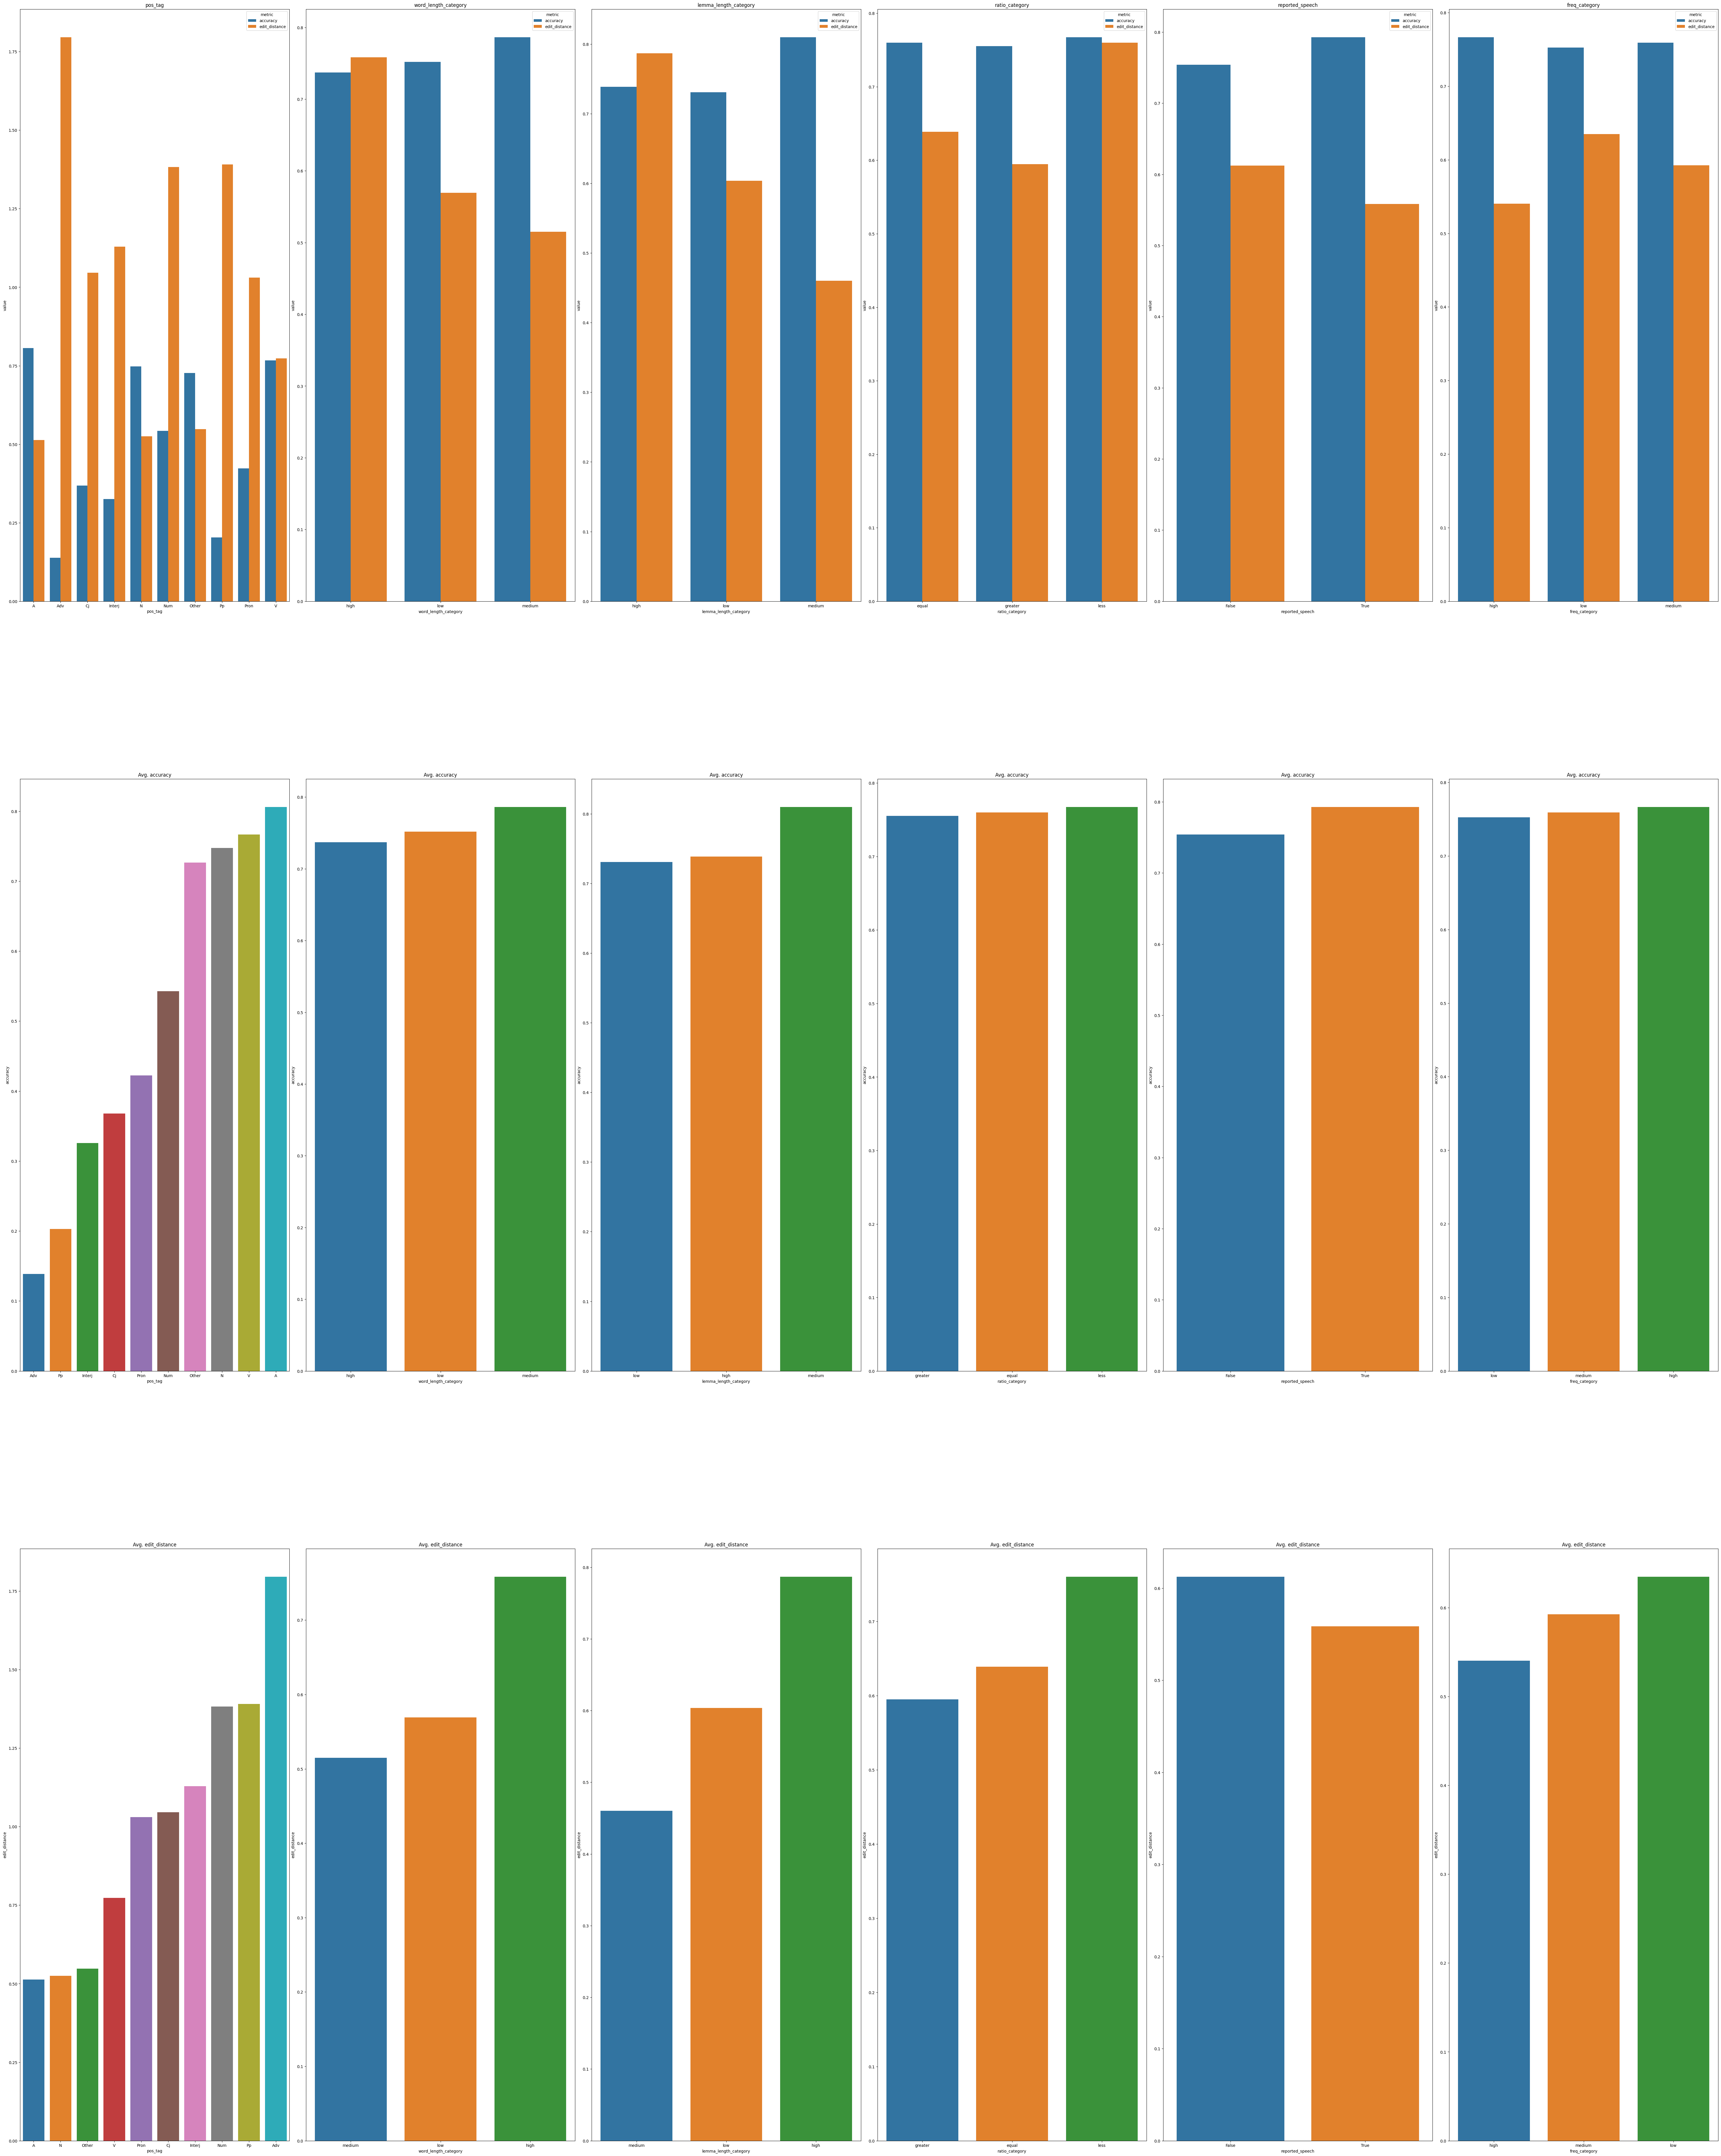

In [10]:
evaluator.evaluate(model, ['pos_tag', 'word_length_category', 'lemma_length_category' , 'ratio_category', 'reported_speech', 'freq_category'])

In [301]:
def get_pred(word: str):
    pad = [vocab[PAD_TOKEN]] * MAX_LENGTH
    word = [vocab[ch] for ch in word] + [vocab[EOW_TOKEN]]
    pad[: len(word)] = word
    inp = torch.unsqueeze(torch.tensor(pad), dim=0)
    return word. tensors_to_words(model(inp).argmax(dim=2))[0]

In [338]:
get_pred('ნივრის')

'ნივრი'

In [339]:
get_pred('ლიმონის')

'ლიმონი'

In [351]:
print(get_pred('ვტირი'))
print(get_pred('ტირი'))
print(get_pred('ტირის'))
print(get_pred('ვტირით'))
print(get_pred('ტირით'))
print(get_pred('ტირიან'))

ტირილი
ტირი
ტირი
ტირილი
ტირი
ტირიანი


In [352]:
print(get_pred('ვტიროდი'))
print(get_pred('ტიროდი'))
print(get_pred('ტიროდა'))
print(get_pred('ვტიროდით'))
print(get_pred('ტიროდით'))
print(get_pred('ტიროდნენ'))

ტირილი
ტირო
ტირო
ტირილი
ტიროდი
ტირილი


In [353]:
print(get_pred('ვიტირებ'))
print(get_pred('იტირებ'))
print(get_pred('იტირებს'))
print(get_pred('ვიტირებთ'))
print(get_pred('იტირებთ'))
print(get_pred('იტირებენ'))

*იტირება
*იტირება
*ტირება
*იტირება
*იტირება
*იტირება


In [354]:
print(get_pred('მეტირა')) 
print(get_pred('გეტირა'))
print(get_pred('ეტირა'))
print(get_pred('გვეტირა'))
print(get_pred('გეტირათ'))
print(get_pred('ეტირათ'))

ტრილი
ტირილი
ტირილი
ტირილი
ტირილი
ტირილი


In [355]:
print(get_pred('მიტირია')) 
print(get_pred('გიტირია'))
print(get_pred('უტირია'))
print(get_pred('გვიტირია'))
print(get_pred('გიტირიათ'))
print(get_pred('უტირიათ'))

ტირილი
ტირილი
უტირი
ტირილი
ტირილი
ტირილი
